In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy

from matplotlib.patches import Rectangle
from os import path
from skimage import io
from torch import optim
from torch.nn import Linear, CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models

## Przygotowanie modelu do klasyfikacji dla zbioru *crop-and-weed-detection-data-with-bounding-boxes*

Przed uruchomieniem tego notebooka, należy zapewnić, że wcześniej uruchomiono notebook `Sesame_data_preparation.ipynb`. W nim dane pobierane są do odpowiednich katalogów oraz wykonywane jest wstępne przygotowanie danych.

In [6]:
input_dir = path.join('..', '..', 'input')
dataset = 'crop-and-weed-detection-data-with-bounding-boxes'
models_dir = path.join('..', 'models')
if not path.exists(path.join(input_dir, dataset)):
     raise SystemExit("No dataset downloaded")
if not path.exists(path.join(input_dir, 'inz-data-prep', 'easy_labels_and_data.csv')):
     raise SystemExit("No data prepared")

In [8]:
labels_frame = pd.read_csv(path.join(input_dir, 'inz-data-prep', 'easy_labels_and_data.csv'), index_col=0)

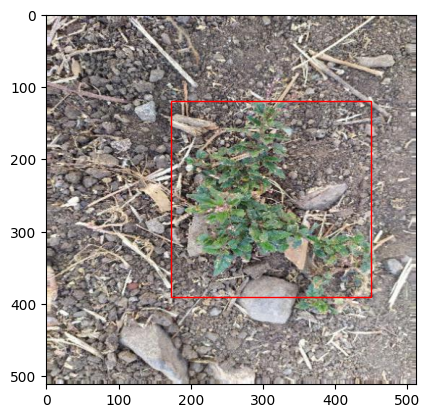

In [9]:
def show_image_bbox(image, bboxes):
    plt.imshow(image)
    ax = plt.gca()
    if isinstance(bboxes, pd.DataFrame):
        for idx, bbox in bboxes.iterrows():
            x = (bbox[0] - bbox[2] / 2) * 512
            y = (bbox[1] - bbox[3] / 2) * 512
            rect = Rectangle((x, y), bbox[2] * 512, bbox[3] * 512, fill=False, edgecolor='r')
            ax.add_patch(rect)
    elif isinstance(bboxes, pd.Series):
        x = (bboxes[0] - bboxes[2] / 2) * 512
        y = (bboxes[1] - bboxes[3] / 2) * 512
        rect = Rectangle((x, y), bboxes[2] * 512, bboxes[3] * 512, fill=False, edgecolor='r')
        ax.add_patch(rect)
    
plt.figure()
show_image_bbox(io.imread(path.join(input_dir, dataset, 'agri_data/data/agri_0_1009.jpeg')), 
               labels_frame.iloc[0, 2:6])
plt.show()

## Torch Dataset

In [10]:
class CropWeedDataset(Dataset):
    
    def __init__(self, labels_csv, images_dir, transform=None):
        self.labels_frame = pd.read_csv(labels_csv, index_col=0)
        self.grouped_labels_frame = self.labels_frame.groupby('filename').sum('label')
        self.images_dir = images_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.grouped_labels_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = path.join(self.images_dir,
                                self.grouped_labels_frame.iloc[idx].name)
        image = io.imread(img_name)
        label = int(self.grouped_labels_frame.iloc[idx, 0] > 0)
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
    def get_bbox(self, idx):
        bbox = self.labels_frame.loc[self.labels_frame['filename'] == self.grouped_labels_frame.iloc[idx].name].iloc[:,2:6]
        return bbox
    
    def show_image(self, idx):
        sample = self[idx]
        bbox = self.get_bbox(idx)

        if self.transform:
            numpy_image = sample['image'].numpy().transpose(1, 2, 0)
        else:
            numpy_image = sample['image']

        show_image_bbox(numpy_image, bbox)

    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image) / 255,
                'label': torch.asarray(label)}

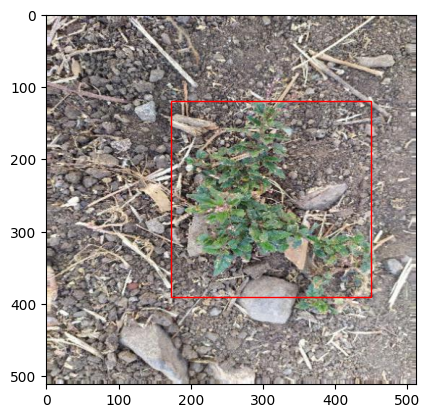

In [11]:
dataset = CropWeedDataset(labels_csv=path.join(input_dir, 'inz-data-prep', 'easy_labels_and_data.csv'),
                          images_dir=path.join(input_dir, dataset, 'agri_data', 'data'),
                          transform=ToTensor())

dataset.show_image(0)

## Dataloader

In [12]:
train, test = random_split(dataset, [950, 204], generator=torch.Generator().manual_seed(420))
dataloaders = {'train':DataLoader(train, batch_size=64, shuffle=True, num_workers=2), 
               'val': DataLoader(test, batch_size=32, shuffle=True, num_workers=2)}
dataset_sizes = {'train': 950,
                'val': 204}

## Model training

In [13]:
from torchvision.models import mnasnet0_5

# Using pretrained weights:

model = mnasnet0_5(pretrained=True)
model.classifier[1] = Linear(1280, 2)

/home/sawcio/Studia/praca inż/thesis_venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sawcio/Studia/praca inż/thesis_venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MNASNet0_5_Weights.IMAGENET1K_V1`. You can also use `weights=MNASNet0_5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Następne części stanowią modyfikację kodu z poradnika *TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL* [https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) autorstwa Sasank Chilamkurthy, dostępnego w ramach licencji BSD.

In [10]:
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [11]:
def train_model(model, criterion, optimizer, num_epochs=10):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = np.inf

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch in dataloaders[phase]:
                inputs = batch['image'].to(device)
                labels = batch['label'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = F.softmax(model(inputs), dim=1)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and (epoch_acc > best_acc or epoch_loss < best_loss):
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
model = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6874 Acc: 0.6758
val Loss: 0.6898 Acc: 0.6029
Epoch 1/9
----------
train Loss: 0.6742 Acc: 0.7232
val Loss: 0.6858 Acc: 0.6127
Epoch 2/9
----------
train Loss: 0.6609 Acc: 0.7368
val Loss: 0.6810 Acc: 0.6471
Epoch 3/9
----------
train Loss: 0.6458 Acc: 0.7589
val Loss: 0.6751 Acc: 0.7500
Epoch 4/9
----------
train Loss: 0.6289 Acc: 0.7779
val Loss: 0.6679 Acc: 0.8284
Epoch 5/9
----------
train Loss: 0.6104 Acc: 0.8158
val Loss: 0.6593 Acc: 0.8480
Epoch 6/9
----------
train Loss: 0.5909 Acc: 0.8368
val Loss: 0.6494 Acc: 0.8725
Epoch 7/9
----------
train Loss: 0.5715 Acc: 0.8621
val Loss: 0.6397 Acc: 0.8775
Epoch 8/9
----------
train Loss: 0.5537 Acc: 0.8874
val Loss: 0.6306 Acc: 0.9167
Epoch 9/9
----------
train Loss: 0.5354 Acc: 0.9095
val Loss: 0.6224 Acc: 0.9167
Best val Acc: 0.916667


In [13]:
torch.save(model.state_dict(), path.join(mdels_dir, 'mnasnet0_5'))